# Exact Amplitude Amplification

The following is a usage example for the `exact_amplitude_amplification` function. 
We will amplify the state $|1\rangle$ out of the state $\sqrt{0.07}|0\rangle + \sqrt{0.93}|1\rangle$.

We provide the function with the following parameters:
- `amplitude`: $\sqrt{0.07}$, the original amplitude of the wanted state.
- `oracle`: $Z$, that will apply a $(-1)$ phase on the $|1\rangle$ state.
- `space_transform`: the state preparation function of the original state.
- `packed_vars`: `x`, the quantum variable to apply on.

Notice that knowledge of the amplitude of the "good" state is need.

In [1]:
import numpy as np

from classiq import *

GOOD_STATE_PROB = 0.07


@qfunc
def prepare_initial_state(x: QBit):
    inplace_prepare_state([1 - GOOD_STATE_PROB, GOOD_STATE_PROB], 0, x)


@qfunc
def main(x: Output[QBit]):
    allocate(x)
    exact_amplitude_amplification(
        np.sqrt(GOOD_STATE_PROB), Z, prepare_initial_state, x  # amplify the |1>  state
    )


qprog = synthesize(main)
write_qmod(main, "exact_amplitude_amplification")
show(qprog)

res = execute(qprog).get_sample_result()
res.dataframe

Quantum program link: https://platform.classiq.io/circuit/31bCC7kOsCvsDd0UpFNHlHQnXXb


,x,count,probability,bitstring
0,1,2048,1.0,1


In [2]:
assert sum(res.dataframe[res.dataframe.x == 1]["count"]) == res.num_shots

The concept in the implementation is to reduce the initial angle between the `good` and `bad` states to be an exact division of 1 by a integer:

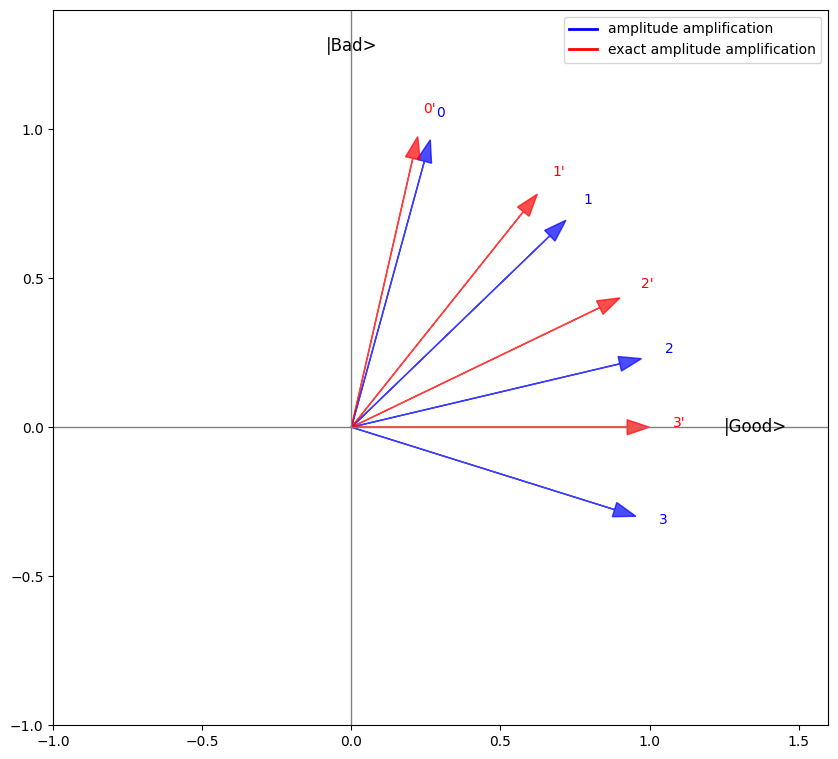

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# angles
theta = np.arcsin(np.sqrt(GOOD_STATE_PROB))
k = int(np.ceil((np.pi / (4 * theta)) - 0.5))
theta_prime = np.pi / (4 * k + 2)


# basis axes (Good on +x, Bad on +y)
GOOD = np.array([1.0, 0.0])
BAD = np.array([0.0, 1.0])

# initial states measured from the +x (GOOD) axis
psi = np.array([np.sin(theta), np.cos(theta)])  # standard
psi_prime = np.array([np.sin(theta_prime), np.cos(theta_prime)])  # ancilla-tuned


def R(a):
    return np.array([[np.cos(a), np.sin(a)], [-np.sin(a), np.cos(a)]])


# each Grover iterate rotates by +2*theta in the GOOD/BAD plane
steps = range(k + 1)
states = [R(2 * k * theta) @ psi for k in steps]
states_prime = [R(2 * k * theta_prime) @ psi_prime for k in steps]

# ---- plot ----
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_aspect("equal")

# axes
plt.axhline(0, color="gray", lw=1)
plt.axvline(0, color="gray", lw=1)
plt.text(1.25, 0, "|Good>", ha="left", va="center", fontsize=12)
plt.text(0, 1.25, "|Bad>", ha="center", va="bottom", fontsize=12)

# standard Grover trajectory (blue)
for k, v in enumerate(states):
    plt.arrow(
        0,
        0,
        v[0],
        v[1],
        head_width=0.05,
        length_includes_head=True,
        color="blue",
        alpha=0.7,
    )
    plt.text(v[0] * 1.08, v[1] * 1.08, f"{k}", color="blue")

# exact (ancilla-tuned) trajectory (red)
for k, v in enumerate(states_prime):
    plt.arrow(
        0,
        0,
        v[0],
        v[1],
        head_width=0.05,
        length_includes_head=True,
        color="red",
        alpha=0.7,
    )
    plt.text(v[0] * 1.08, v[1] * 1.08, f"{k}'", color="red")

# legend handles
legend_elements = [
    Line2D([0], [0], color="blue", lw=2, label="amplitude amplification"),
    Line2D([0], [0], color="red", lw=2, label="exact amplitude amplification"),
]
plt.legend(handles=legend_elements, loc="upper right")

plt.xlim(-1, 1.6)
plt.ylim(-1, 1.4)
plt.show()